In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os, glob

In [ ]:
# !unzip response.zip

# Create Data Structures

In [49]:
N_IMAGES_TRAIN = 20_000
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100

In [50]:
# First we define a custom dataset class to be able to create the DataLoader properly

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, labels_file, img_dir, separator=',', img_type="png",transform=None, max_images=None):
        # As labels, we select the 'c' column of the dataset, which contains the number
        # of circles of the image
        aux = pd.read_csv(labels_file,sep=separator)
        aux.drop(columns=aux.columns[0], axis=1,inplace=True)
        aux.drop(columns=aux.columns[1:], axis=1, inplace=True)
        self.img_labels = aux.to_numpy().squeeze()
        if max_images is not None:
            self.img_labels = self.img_labels[:max_images]
        self.img_dir = img_dir
        self.transform = transform
        self.img_type = img_type

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # To get the images, we transform the index to a 5 long string (so 28 -> 00028)
        # and we use that to read the image.
        img_name = str(idx).zfill(5)+'.'+self.img_type
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        label = self.img_labels[idx,]
        if self.transform:
            image = self.transform(image)
            image = image.float()
        label = torch.tensor(label, dtype=torch.float32)
        return (image, label)

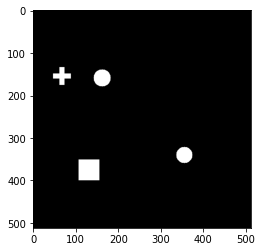

tensor(2.)


In [7]:
# Testing custom dataset is correctly constructed
dummy_dataset = CustomImageDataset(labels_file='data/val/dades.csv', img_dir='data/val', separator=';')
batch = next(iter(dummy_dataset))
plt.imshow(batch[0], cmap='gray')
plt.show()
print(batch[1])

In [51]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])


train_dataset = CustomImageDataset(labels_file='data/train/dades.csv', img_dir='data/train', separator=';', max_images=N_IMAGES_TRAIN, transform=transform)
test_dataset = CustomImageDataset(labels_file='data/val/dades.csv', img_dir='data/val', separator=';', transform=transform)

train_loader = DataLoader(train_dataset, TRAIN_BATCH_SIZE)
test_loader = DataLoader(test_dataset, TEST_BATCH_SIZE)

In [64]:
class FullyConvNet(nn.Module):
    def __init__(self):
        super(FullyConvNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding="same")
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding="same")
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding="same")
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding="same")
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding="same")
        self.conv6 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding="same")
        self.conv7 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding="same")
        self.conv8 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding="same")
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(8*8, 32)
        self.linear2 = nn.Linear(32, 1)
        self.relu =nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.max_pool(x) # out = 64x64x2
        x = self.conv2(x)
        x = self.max_pool(x) # out = 32x32x4
        x = self.conv3(x)
        x = self.max_pool(x) # out = 16x16x8
        x = self.conv4(x)
        x = self.max_pool(x) # out = 8x8x16
        x = self.conv5(x)    # out = 8x8x8
        x = self.conv6(x)    # out = 8x8x4
        x = self.conv7(x)    # out = 8x8x2
        x = self.conv8(x)    # out = 8x8x1
        x = torch.flatten(x,1)
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x.squeeze()

In [62]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        output = model(data)

        loss = loss_func(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target)
            output = torch.round(output)
            correct += output.eq(target.view_as(output)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [ ]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 20
lr = 0.001

model = FullyConvNet().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.MSELoss()

# Guardam el valor de pèrdua promig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)

Parameters  5218
Train Epoch: 0 [0/20000 (0%)]	Loss: 1.254091, Average: 0.009798
Train Epoch: 0 [12800/20000 (64%)]	Loss: 0.656801, Average: 0.005131

Train set: Average loss: 0.0048


Test set: Average loss: 0.0042, Accuracy: 1010/2000 (50%)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.386211, Average: 0.003017
Train Epoch: 1 [12800/20000 (64%)]	Loss: 0.471504, Average: 0.003684

Train set: Average loss: 0.0032


Test set: Average loss: 0.0038, Accuracy: 1087/2000 (54%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.332669, Average: 0.002599
Train Epoch: 2 [12800/20000 (64%)]	Loss: 0.442474, Average: 0.003457

Train set: Average loss: 0.0030


Test set: Average loss: 0.0035, Accuracy: 1132/2000 (57%)

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.316489, Average: 0.002473
Train Epoch: 3 [12800/20000 (64%)]	Loss: 0.418270, Average: 0.003268

Train set: Average loss: 0.0028


Test set: Average loss: 0.0033, Accuracy: 1156/2000 (58%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.295398, Average: 0.002308
Train Epoch